In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta

from keras.optimizers import Adam, SGD, Adadelta

In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled.T

Patient_ID,55_control,168_CD_plain,72_control,120_control,258_CD_plain,254_CD_deep_ulcer,9_CD_plain,111_CD_plain,57_CD_plain,216_CD_deep_ulcer,...,303_CD_plain,35_control,148_CD_deep_ulcer,28_control,67_control,15_CD_plain,182_CD_plain,164_CD_plain,53_CD_plain,97_CD_plain
AADAC,0.702813,0.751408,0.786508,0.707491,0.701039,0.688952,0.626994,0.591800,0.776578,0.392511,...,0.781692,0.868755,0.820946,0.913545,0.935844,0.382762,0.679910,0.754656,0.591140,0.817125
APOA1,0.799052,0.603707,0.755331,0.662993,0.662511,0.790972,0.486913,0.677731,0.776586,0.306222,...,0.706428,0.777184,0.897985,0.873595,0.848575,0.384030,0.584723,0.556562,0.585802,0.782223
APOA4,0.719665,0.622768,0.739605,0.648072,0.707208,0.730387,0.686100,0.627623,0.817773,0.540222,...,0.762380,0.832517,0.934965,0.907560,0.854504,0.377332,0.722426,0.694062,0.750282,0.854442
APOB,0.729547,0.627712,0.756170,0.764621,0.834562,0.698611,0.568230,0.548575,0.688612,0.462697,...,0.824484,0.826357,0.816291,0.820765,0.864477,0.360165,0.643867,0.748334,0.753309,0.867360
APOC3,0.794953,0.606860,0.819875,0.654276,0.670160,0.814798,0.636292,0.670497,0.893823,0.430877,...,0.669462,0.724312,0.919488,0.852810,0.836009,0.300915,0.740014,0.535534,0.603372,0.793421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RSL24D1P1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MIEN1,0.543158,0.623796,0.853118,0.392582,0.259900,0.704568,0.376074,0.750395,0.793754,0.237463,...,0.238152,0.334790,1.000000,0.662575,0.543671,0.262892,0.413798,0.273699,0.183718,0.561414
PCBP1_AS1,0.622641,0.301179,0.431083,0.390569,0.431818,0.123324,0.241705,0.534881,0.439487,0.283500,...,0.366623,0.219109,0.539350,0.341922,0.391775,0.189790,0.270021,0.433093,0.302030,0.027077
LOC100133165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


## Full workflow

In [4]:
from numpy import inf
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA

### Calculate gene statistics

In [5]:
x_stats = x_test_scaled.describe().iloc[[1,2,3,-1]]

In [6]:
x_stats

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
mean,0.662326,0.615285,0.670829,0.658361,0.625205,0.459972,0.344742,0.345704,0.546377,0.595752,...,0.359887,0.248426,0.0,0.777372,0.440612,0.0,0.418557,0.331811,0.0,0.009305
std,0.186037,0.208824,0.196106,0.209957,0.200946,0.243852,0.282902,0.209450,0.221981,0.245207,...,0.106041,0.083038,0.0,0.129976,0.238418,0.0,0.197838,0.106248,0.0,0.082177
min,0.165531,0.141475,0.179189,0.041787,0.105744,0.000000,0.000000,0.000000,0.037820,0.077684,...,0.107633,-0.031527,0.0,0.323550,0.000000,0.0,0.048748,0.061934,0.0,0.000000
max,0.930585,1.029728,0.969910,0.950466,0.980092,1.151876,1.191519,0.915734,0.997430,1.042678,...,0.681479,0.404644,0.0,1.013531,1.221905,0.0,1.013627,0.701615,0.0,0.725770


In [7]:
gene_means = x_stats.iloc[0,:].values

In [8]:

gene_stds = x_stats.iloc[1,:].values

In [9]:
gene_vars = np.square(gene_stds)

### Build covariance matrix

In [10]:
n = x_test_scaled.shape[1]
cov = np.zeros((n,n))
cov.shape

(219, 219)

### Calculate correlations using KL divergence

In [11]:


# https://jamesmccaffrey.wordpress.com/2021/02/03/the-kullback-leibler-divergence-for-two-gaussian-distributions/
def kld_gauss(u1, s1, u2, s2):
  # general KL two Gaussians
  # u2, s2 often N(0,1)
  # https://stats.stackexchange.com/questions/7440/ +
  # kl-divergence-between-two-univariate-gaussians
  # log(s2/s1) + [( s1^2 + (u1-u2)^2 ) / 2*s2^2] - 0.5
  v1 = s1 * s1
  v2 = s2 * s2
  if s1 == 0:
    s1 = 0.005
  a = np.log(s2/s1) 
  num = v1 + (u1 - u2)**2
  den = 2 * v2
  if den == 0:
    den = 0.005
  b = num / den
  return a + b - 0.5

def build_cov_matrix(gene_means, gene_stds):
    min_v = inf
    max_v = -inf
    for i in range(n):
        curr_mean = gene_means[i]
        curr_std = gene_stds[i]

        for j in range(i+1, n):
            other_mean = gene_means[j]
            other_std = gene_stds[j]
            kl = kld_gauss(curr_mean, curr_std, other_mean, other_std)
            cov[i][j] = kl

            #max/min
            min_v = min(min_v, kl)
            max_v = max(max_v, kl)
    return cov, min_v, max_v

cov, min_v, max_v = build_cov_matrix(gene_means, gene_stds)
        


C:\Users\shard\AppData\Local\Temp\ipykernel_30180\1465387533.py:12: RuntimeWarning: divide by zero encountered in log
  a = np.log(s2/s1)


In [12]:
print(min_v)
print(max_v)

-inf
3242.75701710342


In [13]:
nans = np.isnan(cov)
np.all(nans == False)

True

In [14]:

cov[cov == -inf] = -max_v
cov[cov == inf] = max_v

In [15]:
for row in cov[:10]:
    print(row[:5])

[0.         0.03775068 0.00362284 0.01369654 0.02271162]
[0.         0.         0.04422957 0.02107563 0.00273583]
[0.         0.         0.         0.00621603 0.02636019]
[0.         0.         0.         0.         0.01559476]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


### Scale down correlations

In [16]:

standard_scaler = MinMaxScaler((0,.1))
cov_matrix = standard_scaler.fit_transform(cov)

In [17]:
# reduce scale of correlations even more
# cov_matrix /= 10

In [18]:
for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.         0.         0.1        0.1        0.01037864]
[0.         0.         0.         0.02949391 0.1       ]
[0.         0.         0.         0.         0.05916027]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


In [19]:
cov_matrix = .1 - cov_matrix

### Reflection to lower triangle

In [20]:
# https://stackoverflow.com/questions/16444930/copy-upper-triangle-to-lower-triangle-in-a-python-matrix
i_lower = np.tril_indices(n, -1)
cov_matrix[i_lower] = cov_matrix.T[i_lower]  # make the matrix symmetric

for row in cov_matrix[:10]:
    print(row[:5])

[0.1        0.         0.091809   0.03501243 0.01384122]
[0.         0.1        0.         0.         0.08962136]
[0.091809   0.         0.1        0.07050609 0.        ]
[0.03501243 0.         0.07050609 0.1        0.04083973]
[0.01384122 0.08962136 0.         0.04083973 0.1       ]
[0.00221357 0.04590185 0.         0.01538299 0.03673654]
[0.00071633 0.03082919 0.         0.01075703 0.02402848]
[0.00441205 0.03148426 0.         0.00783939 0.02621187]
[0.06593307 0.08926297 0.06446539 0.07298757 0.08499669]
[0.08155131 0.09516632 0.08350835 0.09005037 0.09230234]


In [21]:
np.fill_diagonal(cov_matrix, gene_vars)

In [22]:
for row in cov_matrix[:10]:
    print(row[:5])

[0.0346099  0.         0.091809   0.03501243 0.01384122]
[0.         0.04360728 0.         0.         0.08962136]
[0.091809   0.         0.03845744 0.07050609 0.        ]
[0.03501243 0.         0.07050609 0.04408185 0.04083973]
[0.01384122 0.08962136 0.         0.04083973 0.04037916]
[0.00221357 0.04590185 0.         0.01538299 0.03673654]
[0.00071633 0.03082919 0.         0.01075703 0.02402848]
[0.00441205 0.03148426 0.         0.00783939 0.02621187]
[0.06593307 0.08926297 0.06446539 0.07298757 0.08499669]
[0.08155131 0.09516632 0.08350835 0.09005037 0.09230234]


### Processing - conditional genes & matrix adjustment

In [23]:
mod_gene_stds = gene_stds.copy()
mod_gene_means = gene_means.copy()


In [24]:
# if conditional genes, reset corresponding means
# mod_gene_means[0] = 0.7
# mod_gene_means[1] = 0.6
mod_gene_means[0] = 0.9
mod_gene_means[6] = 0.9


# then set 0 variances and stds
cond_gene_ids = [0,1]

def set_cond_vars(cond_gene_ids, cov_matrix, gene_stds):
    for idx in cond_gene_ids:
        cov_matrix[idx][idx] = 0.
        gene_stds[idx] = 0.
    return cov_matrix, gene_stds

cov_matrix, mod_gene_stds = set_cond_vars(cond_gene_ids, cov_matrix, mod_gene_stds)

In [25]:

# cond_cov_matrix[1:3,2:5] = 0
# cond_cov_matrix[2:5,1:3] = 0
for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.         0.091809   0.03501243 0.01384122]
[0.         0.         0.         0.         0.08962136]
[0.091809   0.         0.03845744 0.07050609 0.        ]
[0.03501243 0.         0.07050609 0.04408185 0.04083973]
[0.01384122 0.08962136 0.         0.04083973 0.04037916]
[0.00221357 0.04590185 0.         0.01538299 0.03673654]
[0.00071633 0.03082919 0.         0.01075703 0.02402848]
[0.00441205 0.03148426 0.         0.00783939 0.02621187]
[0.06593307 0.08926297 0.06446539 0.07298757 0.08499669]
[0.08155131 0.09516632 0.08350835 0.09005037 0.09230234]


In [26]:
# adjust matrix to make it positive definite 
w, v = LA.eig(cov_matrix)
cond_cov_matrix = cov_matrix + (abs(np.min(w)) + 1e-7)*np.identity(n)

In [27]:
for row in cond_cov_matrix[:10]:
    print(row[:5])

[2.68216679 0.         0.091809   0.03501243 0.01384122]
[0.         2.68216679 0.         0.         0.08962136]
[0.091809   0.         2.72062424 0.07050609 0.        ]
[0.03501243 0.         0.07050609 2.72624865 0.04083973]
[0.01384122 0.08962136 0.         0.04083973 2.72254595]
[0.00221357 0.04590185 0.         0.01538299 0.03673654]
[0.00071633 0.03082919 0.         0.01075703 0.02402848]
[0.00441205 0.03148426 0.         0.00783939 0.02621187]
[0.06593307 0.08926297 0.06446539 0.07298757 0.08499669]
[0.08155131 0.09516632 0.08350835 0.09005037 0.09230234]


In [28]:
np.max(cov_matrix)

0.101810760680313

In [29]:
np.max(cond_cov_matrix)

2.7839775550008916

In [30]:
def get_patient_sample(means, cov_matrix, gene_stds, allow_singular=False):
    rv = multivariate_normal(means, cov_matrix, allow_singular=allow_singular)
    sample = rv.rvs(size=1, random_state=10) # sample gene expression for a dummy patient
    # account for rescaled variances when making cov matrix positive semidefinite
    rescaled_sample = (sample - means) * gene_stds + means
    return np.clip(rescaled_sample, 0, 1)

patient_sample = get_patient_sample(mod_gene_means, cond_cov_matrix, mod_gene_stds)
patient_sample

array([0.9       , 0.61528512, 0.36713033, 0.10096227, 0.59229745,
       0.48167216, 1.        , 0.53320291, 0.        , 0.43850046,
       0.47067982, 0.03384612, 0.10242272, 0.68980306, 0.48633041,
       0.28240821, 0.36563127, 0.23255467, 0.43102463, 0.30805767,
       0.67561101, 1.        , 0.31182692, 0.40794026, 0.53567004,
       0.        , 0.26497239, 0.6928211 , 0.36521344, 0.30359082,
       0.6227981 , 0.38399616, 0.14174004, 0.27182756, 0.59511391,
       0.26952245, 0.        , 1.        , 0.53110669, 0.10162266,
       1.        , 0.72271507, 0.04828518, 1.        , 0.        ,
       0.41627311, 0.49088932, 0.37523317, 0.49377748, 0.        ,
       0.43463096, 0.40447432, 0.42291414, 1.        , 0.        ,
       0.        , 0.36901364, 0.19804763, 0.        , 0.75191804,
       0.35033501, 0.79395974, 0.18654698, 0.7558622 , 0.85401431,
       0.10693484, 0.        , 0.11556568, 0.        , 0.50675287,
       1.        , 0.17290619, 0.07675092, 0.01488727, 0.     

In [31]:
patient_sample.min()

0.0

In [32]:
# ensure correct values set known genes
patient_sample[0] = 0.9 #AADAC
patient_sample[6] = 0.9 #OSM

In [33]:
patient_sample

array([0.9       , 0.61528512, 0.36713033, 0.10096227, 0.59229745,
       0.48167216, 0.9       , 0.53320291, 0.        , 0.43850046,
       0.47067982, 0.03384612, 0.10242272, 0.68980306, 0.48633041,
       0.28240821, 0.36563127, 0.23255467, 0.43102463, 0.30805767,
       0.67561101, 1.        , 0.31182692, 0.40794026, 0.53567004,
       0.        , 0.26497239, 0.6928211 , 0.36521344, 0.30359082,
       0.6227981 , 0.38399616, 0.14174004, 0.27182756, 0.59511391,
       0.26952245, 0.        , 1.        , 0.53110669, 0.10162266,
       1.        , 0.72271507, 0.04828518, 1.        , 0.        ,
       0.41627311, 0.49088932, 0.37523317, 0.49377748, 0.        ,
       0.43463096, 0.40447432, 0.42291414, 1.        , 0.        ,
       0.        , 0.36901364, 0.19804763, 0.        , 0.75191804,
       0.35033501, 0.79395974, 0.18654698, 0.7558622 , 0.85401431,
       0.10693484, 0.        , 0.11556568, 0.        , 0.50675287,
       1.        , 0.17290619, 0.07675092, 0.01488727, 0.     

In [34]:
# test_sample using only variance, no correlations
test_cov = np.zeros((n,n))
np.fill_diagonal(test_cov, gene_vars) 

rv_test = multivariate_normal(gene_means, test_cov, allow_singular=True)
test_sample = np.clip(rv_test.rvs(size=1, random_state=None), 0, 1)

# set known values
test_sample[0] = 0.7
test_sample[1] = 0.6

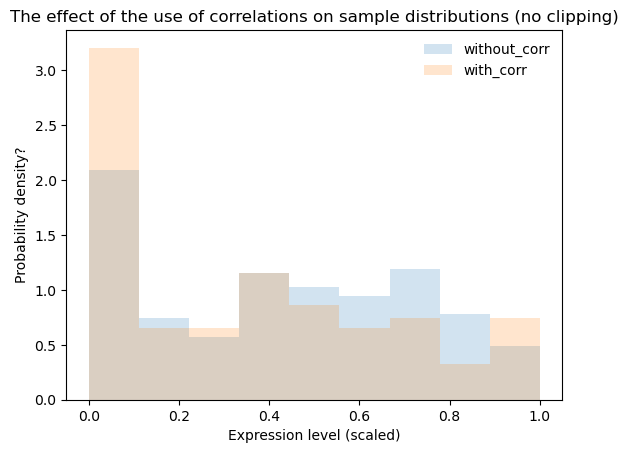

In [35]:
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(test_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
ax.hist(patient_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label="with_corr")
# ax.hist(rescaled_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')
ax.set_title("The effect of the use of correlations on sample distributions ")
ax.set_xlabel("Expression level (scaled)")
ax.set_ylabel("Probability density?")


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

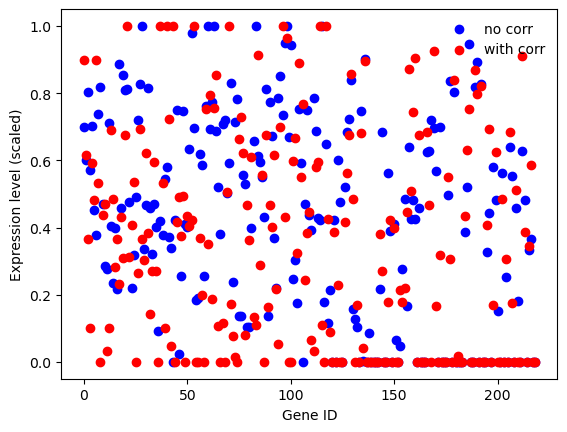

In [37]:
fig, ax = plt.subplots(1, 1)
xr = np.arange(219)
ax.scatter(xr, test_sample, c='b', label="no corr")
ax.scatter(xr, patient_sample, c='r', label="with corr")


# ax.set_title("The effect of the use of correlations on sample distributions")
ax.set_xlabel("Gene ID")
ax.set_ylabel("Expression level (scaled)")


ax.legend(loc='best', frameon=False)
plt.show()

## Calculate SHAP values

In [36]:
shap_values[0].shape

NameError: name 'shap_values' is not defined

In [ ]:
shap_values = explainer.shap_values(X=x_test_scaled[:2])

In [ ]:
shap_values

## Save SHAP values

In [ ]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [ ]:


with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [ ]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')